In [45]:
import kwant
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import notebook

In [46]:
def make_system(a=1, t=1, W=10, r1=10, r2=20):
    lat = kwant.lattice.square(a)
    syst = kwant.Builder()
    
    def ring(pos):
        (x,y) = pos
        rsq = x**2 + y**2
        return (r1**2<rsq<r2**2)
    
    syst[lat.shape(ring,(0,r1+1))] = 4*t
    syst[lat.neighbors()] = -t
    
    def hopping_phase(site1, site2, phi):
        return -t * np.exp(1j * phi)
    
    def crosses_branchcut(hop):
        ix0,iy0 = hop[0].tag
        
        return iy0<0 and ix0==1
    
    def hops_across_cut(syst):
        for hop in kwant.builder.HoppingKind((1,0), lat, lat)(syst):
            if crosses_branchcut(hop):
                yield hop
    syst[hops_across_cut] = hopping_phase
    
    sym_lead = kwant.TranslationalSymmetry((-a,0))
    lead = kwant.Builder(sym_lead)
    
    def lead_shape(pos):
        (x,y) = pos
        return (-W/2<y<W/2)
    
    lead[lat.shape(lead_shape,(0,0))] = 4*t
    lead[lat.neighbors()] = -t
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    
    return syst

In [12]:
syst = make_system()

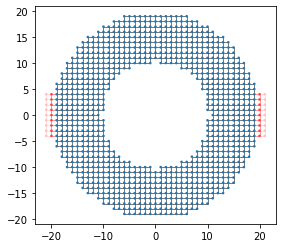

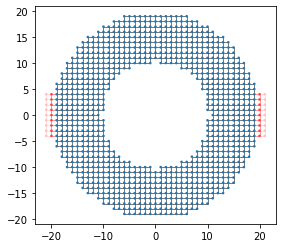

In [13]:
kwant.plot(syst)

In [14]:
syst= syst.finalized()

In [15]:
smatrix = kwant.smatrix(syst,1,params = dict(phi = np.pi))

In [42]:
# Compute conductance

phi_list= np.linspace(0,3*2*np.pi,100)
energy_list = np.linspace(0,3,100)
datamap = []
for energy in tqdm(energy_list):
    data = []
    for phi0 in phi_list:
        smatrix = kwant.smatrix(syst,1, params=dict(phi = phi0))
        data.append(smatrix.transmission(1, 0))
    datamap.append(data)



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:03<00:00,  2.43s/it]


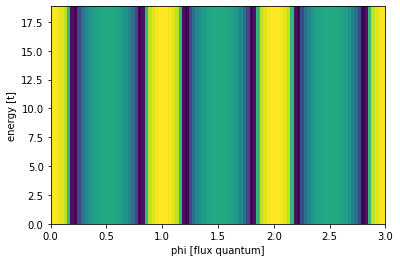

In [43]:
plt.figure()
plt.pcolor(energy_list,phi_list,datamap)
plt.xlabel("phi [flux quantum]")
plt.ylabel("energy [t]")
plt.show()